![](./servo.png)

In [50]:
from control import tf, forced_response, ss

In [2]:
β = 1
Ka = 1
La = 1
Ra = 1
K = 1
Kb = 1
Jm = 1
Bm = 1

In [3]:
servo = tf(β, 1)*tf(Ka, 1)*(tf(1,[La, Ra])*tf(K, 1)*tf(1, [Jm, Bm])).feedback(tf(Kb, 1))*tf(1, [1,1])
servo


          1
---------------------
s^3 + 3 s^2 + 4 s + 2

In [51]:
a, b = 2, 50
servo_vel = tf(b, [1, a])
derivada = tf([1, 0], [0, 1])
integral = tf(1, [1, 0])
ss(servo_vel)

A = [[-2.]]

B = [[ 5.]]

C = [[ 10.]]

D = [[ 0.]]

In [5]:
from numpy.random import normal
from numpy import linspace
from scipy.signal import resample

t0, tfin = 0, 30
periodo_integracion = 0.001

muestras = int(1/periodo_integracion)

ruido = normal(0, 0.001, 100)
t = linspace(t0, tfin, 100)

ruido, t = resample(ruido, tfin*muestras, t)

In [11]:
%matplotlib inline
from matplotlib.pyplot import figure, style
style.use('ggplot')

In [12]:
style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

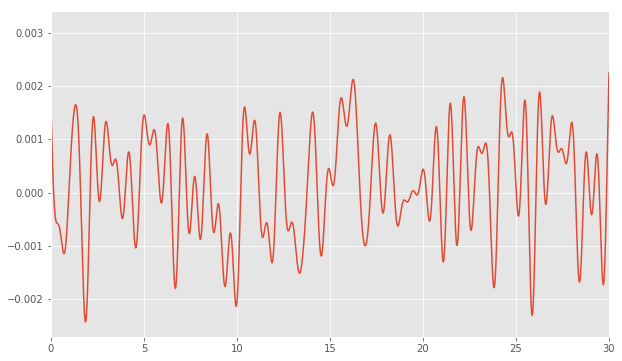

In [13]:
fig = figure(figsize=(10, 6))
ax = fig.gca()
ax.plot(t, ruido)
ax.set_xlim(t0, tfin);

In [14]:
filtro = tf(20, [1, 20])
filtro


  20
------
s + 20

In [15]:
ts, ruido_filtrado, xs = forced_response(filtro, t, ruido, 0)

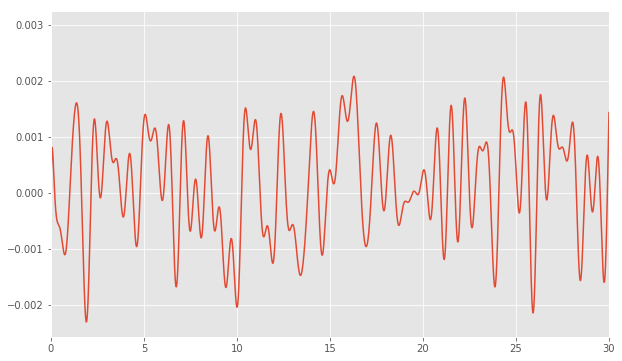

In [16]:
fig = figure(figsize=(10, 6))
ax = fig.gca()
ax.plot(ts, ruido_filtrado)
ax.set_xlim(t0, tfin);

In [17]:
kp, kd = 9, 2
P = tf(kp, 1)
D = tf(kd, 1)

In [18]:
servo_vel


  50
-----
s + 2

In [19]:
servo_vel.feedback(D)


  50
-------
s + 102

In [20]:
servo_control_velocidad = (P*servo_vel.feedback(D)*integral).feedback()
servo_control_velocidad


       450
-----------------
s^2 + 102 s + 450

In [21]:
from numpy import sin
señal_senoidal = sin(t)
ts, señal_senoidal_filtrada, xs = forced_response(filtro, t, señal_senoidal)

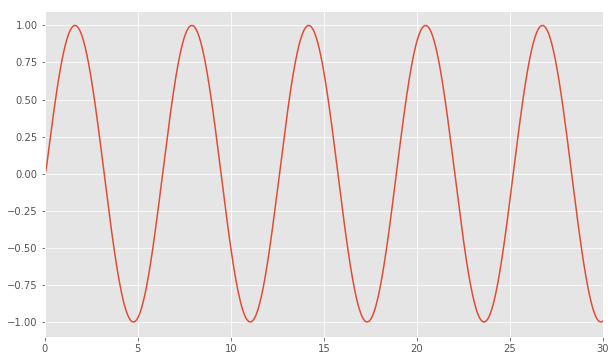

In [22]:
fig = figure(figsize=(10, 6))
ax = fig.gca()
ax.plot(ts, señal_senoidal_filtrada)
ax.set_xlim(t0, tfin);

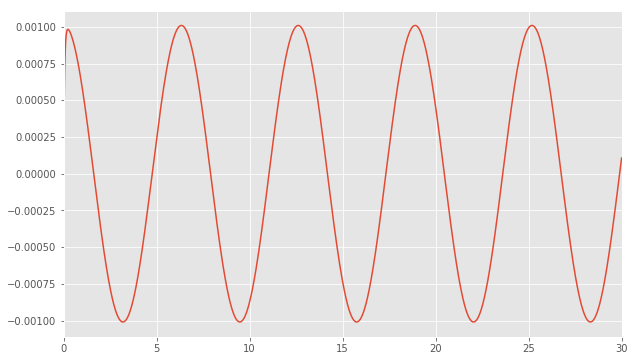

In [41]:
fig = figure(figsize=(10, 6))
ax = fig.gca()
ax.plot(ts, gradient(señal_senoidal_filtrada))
ax.set_xlim(t0, tfin);

In [23]:
ts, respuesta_servo_controlado, xs = forced_response(servo_control_velocidad, t, señal_senoidal_filtrada)

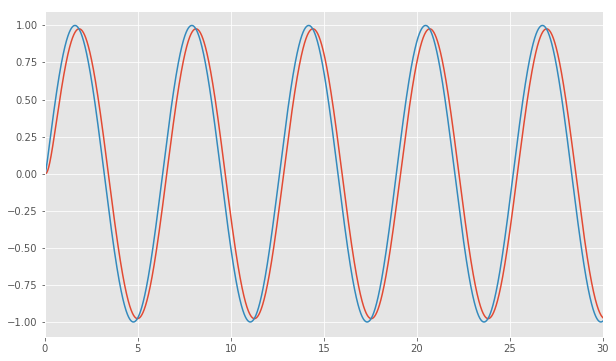

In [24]:
fig = figure(figsize=(10, 6))
ax = fig.gca()
ax.plot(ts, respuesta_servo_controlado)
ax.plot(ts, señal_senoidal_filtrada)
ax.set_xlim(t0, tfin);

In [25]:
ts, respuesta_servo_control_velocidad, xs = forced_response(servo_control_velocidad, t, ruido_filtrado)

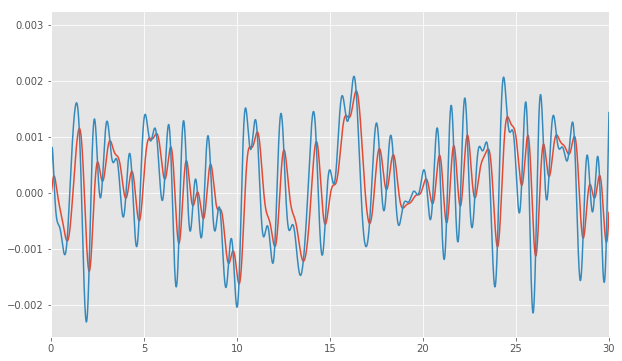

In [26]:
fig = figure(figsize=(10, 6))
ax = fig.gca()
ax.plot(ts, respuesta_servo_control_velocidad)
ax.plot(ts, ruido_filtrado)
ax.set_xlim(t0, tfin);

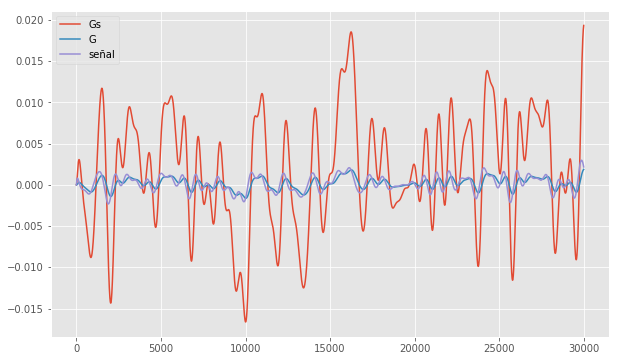

In [27]:
fig = figure(figsize=(10, 6))
ax = fig.gca()
p1, p2, = ax.plot(-xs.transpose())
p3, = ax.plot(ruido_filtrado)
ax.legend([p1, p2, p3], ["Gs", "G", "señal"]);

In [28]:
from numpy import gradient

In [29]:
y = respuesta_servo_control_velocidad
ref = ruido_filtrado
v1 = 9*(ref - y)
v2 = 2*gradient(respuesta_servo_control_velocidad)
u = v1 - v2

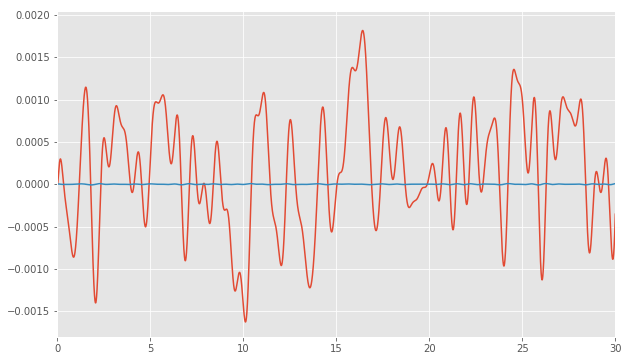

In [47]:
fig = figure(figsize=(10, 6))
ax = fig.gca()
ax.plot(ts, respuesta_servo_control_velocidad)
ax.plot(ts, gradient(respuesta_servo_control_velocidad, edge_order=1))
ax.set_xlim(t0, tfin);

In [44]:
gradient?

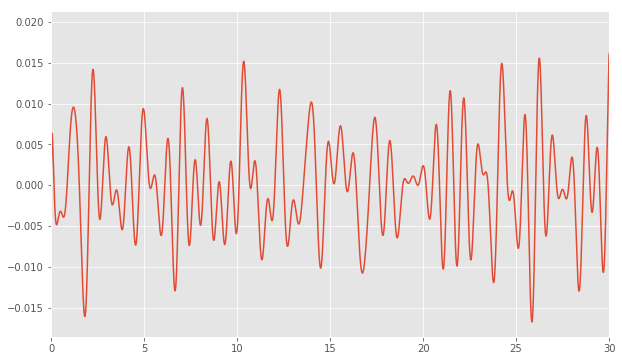

In [30]:
fig = figure(figsize=(10, 6))
ax = fig.gca()
ax.plot(ts, u)
ax.set_xlim(t0, tfin);

In [31]:
fso1 = tf([400, 0, 0], [1, 40, 400])
fso2 = tf([-400, 0], [1, 40, 400])
fso3 = tf([400], [1, 40, 400])

In [32]:
ts,  B, xs = forced_response(fso1, t, y)
ts, A1, xs = forced_response(fso2, t, y)
ts, A2, xs = forced_response(fso3, t, u)

In [33]:
from numpy import matrix

In [34]:
A = matrix([A1, A2])

In [35]:
B = matrix(B).T

In [36]:
from numpy.linalg import pinv, eig

In [37]:
pinv(A.T)*B

matrix([[ 101.89975676],
        [  50.00025656]])

In [38]:
λs, E = eig(A*A.T)
λmax, λmin = max(λs), min(λs)
κ = λmax/λmin
κ

1487.6566049138696

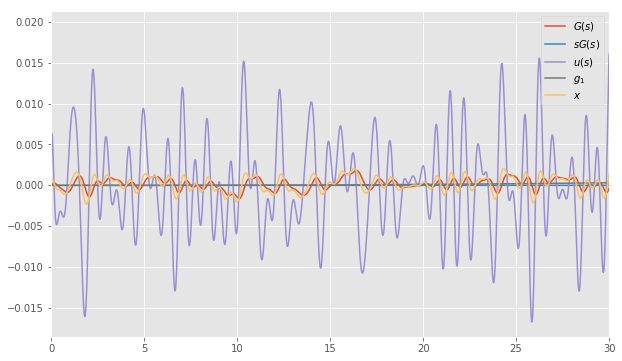

In [39]:
fig = figure(figsize=(10, 6))
ax = fig.gca()
p1, = ax.plot(ts, y)
p2, = ax.plot(ts, gradient(y))
p3, = ax.plot(ts, u)
p4, = ax.plot(-xs[1].transpose())
p5, = ax.plot(ts, ref)
ax.legend([p1, p2, p3, p4, p5], [r"$G(s)$", r"$sG(s)$", r"$u(s)$", r"$g_1$", r"$x$"])
ax.set_xlim(t0, tfin);